# $m<0$

Text(0, 0.5, 'y')

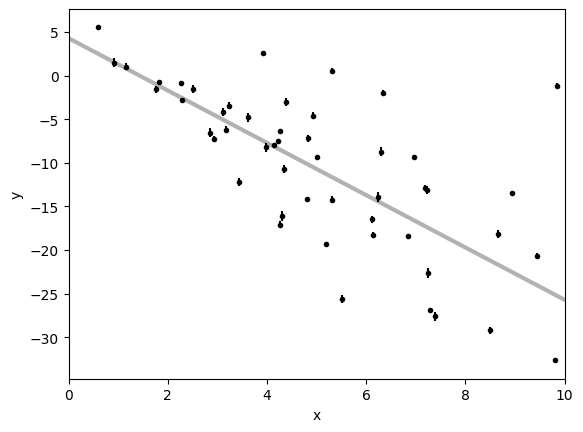

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -3
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Least-squares estimates:
m = -2.799 ± 0.016
b = 4.255 ± 0.091


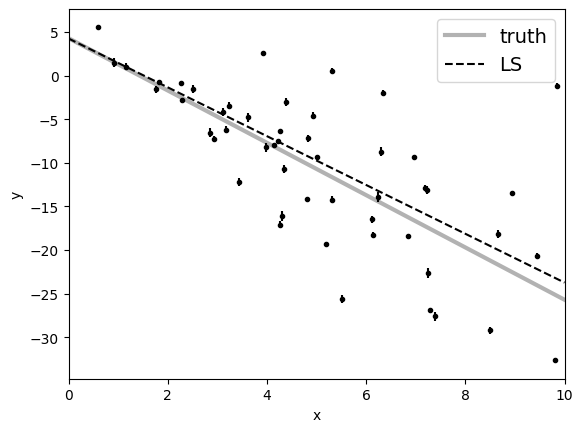

In [2]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


In [3]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -3.097
b = 4.606
f = 0.548


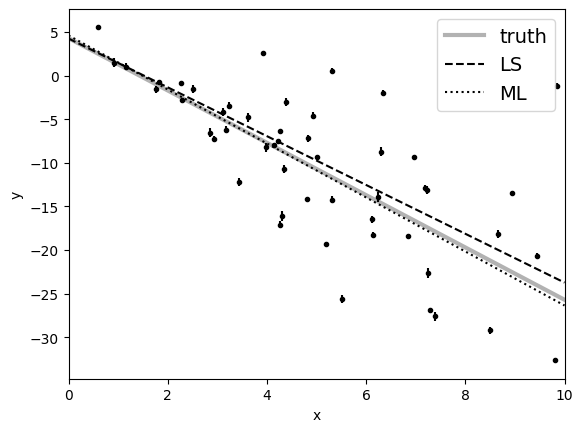

In [4]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


In [5]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [6]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [7]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:02<00:00, 2174.55it/s]


State([[-2.88684251  3.66456903 -0.47906287]
 [-2.9361827   4.53164283 -0.70746976]
 [-3.2227269   4.91598938 -0.66605324]
 [-2.80084402  4.27192376 -0.52499998]
 [-2.97969886  4.18495025 -0.51923654]
 [-2.84801311  4.20854065 -0.58716114]
 [-3.32347619  5.07284848 -0.62631747]
 [-2.44079848  3.48636121 -0.37527721]
 [-3.07492999  4.66258613 -0.65040293]
 [-2.75590727  4.38627886 -0.43816678]
 [-3.43765848  5.35892706 -0.60722341]
 [-3.15342947  4.71067904 -0.71681629]
 [-3.40437499  4.98680579 -0.71382323]
 [-3.29243855  5.01259271 -0.7459309 ]
 [-3.04035276  4.57696212 -0.69659238]
 [-3.17530439  4.89595399 -0.55945887]
 [-3.21871732  4.53536876 -0.768207  ]
 [-3.1217993   4.91690078 -0.58903624]
 [-3.34215045  5.18979111 -0.33662485]
 [-2.89039273  4.00425175 -0.59736129]
 [-3.0861385   4.68425694 -0.73182182]
 [-3.13762604  4.51413113 -0.71247961]
 [-2.55938651  3.57327843 -0.45492739]
 [-2.71325323  4.16155564 -0.49906274]
 [-3.28643472  4.94367329 -0.58917535]
 [-3.14868806  4.68

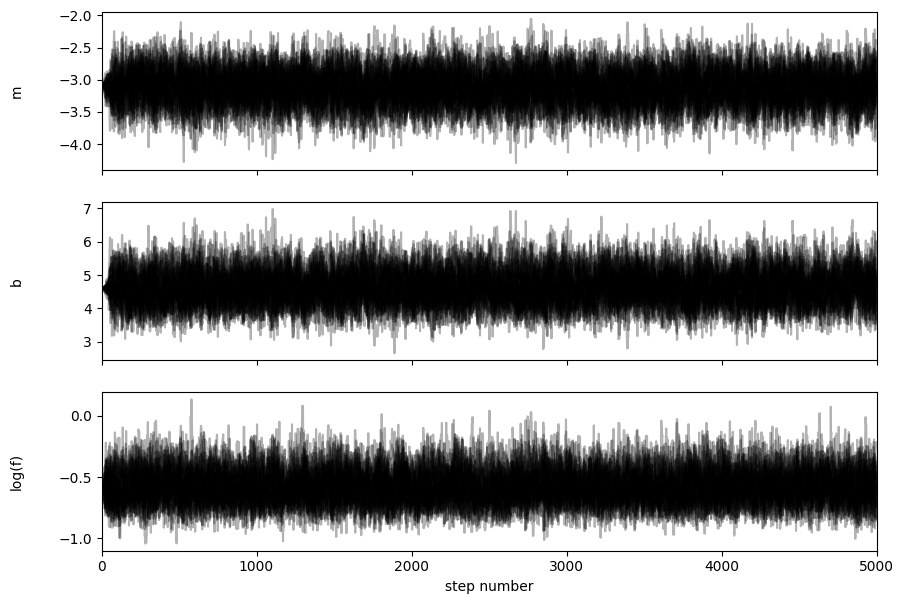

In [8]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [9]:
tau = sampler.get_autocorr_time()
print(tau)

[41.0129553  40.38713887 43.70150313]


In [10]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


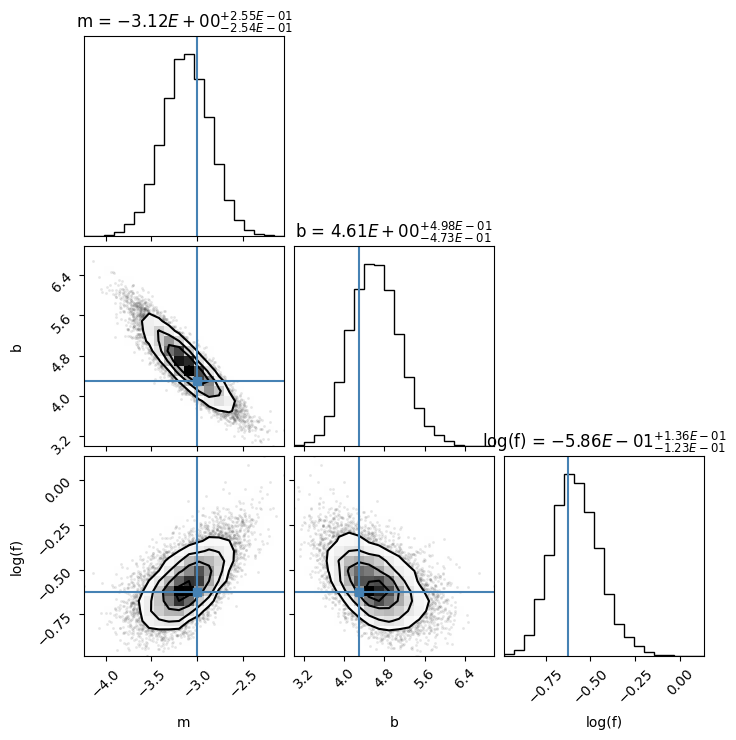

In [11]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

In [12]:
# Extract the samples
samples = sampler.get_chain()

# Calculate mean and standard deviation for each parameter
mean_theta1 = np.mean(samples[:, :, 0])
std_theta1 = np.std(samples[:, :, 0])

mean_theta2 = np.mean(samples[:, :, 1])
std_theta2 = np.std(samples[:, :, 1])

mean_sigma = np.mean(samples[:, :, 2])
std_sigma = np.std(samples[:, :, 2])

# Print the results
print("Theta1: {:.3f} ± {:.3f}".format(mean_theta1, std_theta1))
print("Theta2: {:.3f} ± {:.3f}".format(mean_theta2, std_theta2))
print("Sigma: {:.3f} ± {:.3f}".format(mean_sigma, std_sigma))


Theta1: -3.116 ± 0.258
Theta2: 4.626 ± 0.491
Sigma: -0.580 ± 0.132


# $m>0$

Text(0, 0.5, 'y')

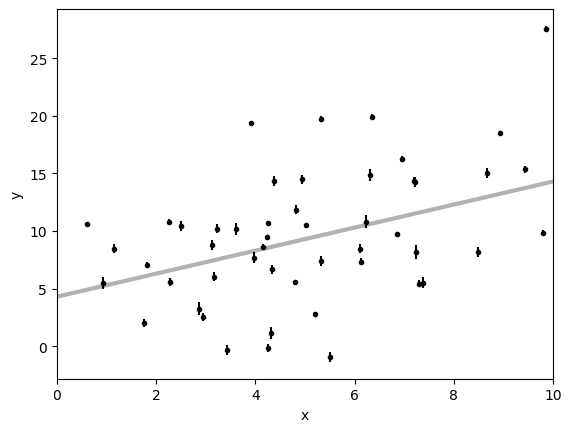

In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = 1
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Least-squares estimates:
m = 0.821 ± 0.016
b = 6.239 ± 0.091


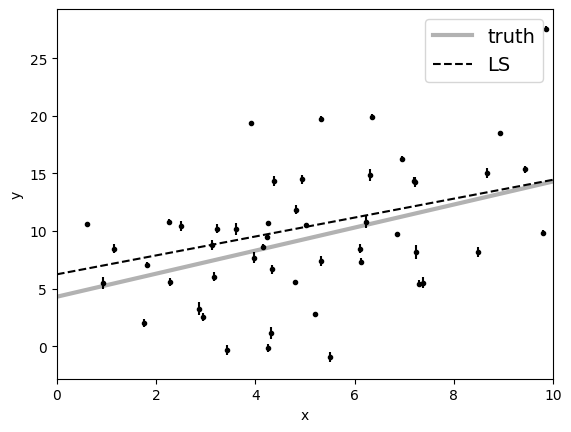

In [14]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


In [15]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = 0.835
b = 5.334
f = 0.537


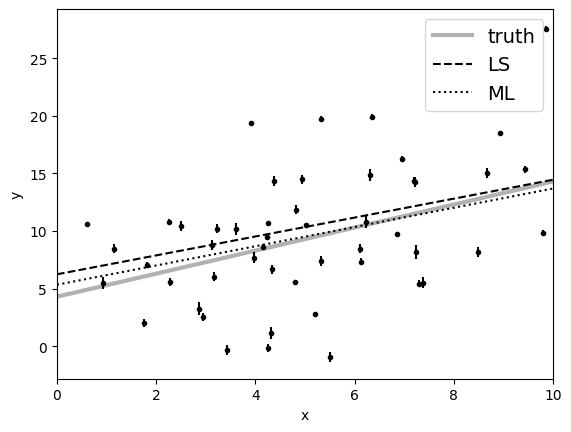

In [16]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");


In [17]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [18]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [19]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:01<00:00, 4312.24it/s]


State([[ 0.83525393  5.33379721 -0.62132097]
 [ 0.83525954  5.33389736 -0.62134451]
 [ 0.83515588  5.33377428 -0.62134413]
 [ 0.83512582  5.33362929 -0.62147005]
 [ 0.83504539  5.33371934 -0.62126613]
 [ 0.83501082  5.33367939 -0.62115099]
 [ 0.83507905  5.33382737 -0.62144003]
 [ 0.83504718  5.33383171 -0.62141266]
 [ 0.83513919  5.33376056 -0.62132673]
 [ 0.83504145  5.33400585 -0.62129891]
 [ 0.83499585  5.33390288 -0.62141964]
 [ 0.83512251  5.33362465 -0.62143038]
 [ 0.83512131  5.33389447 -0.62128042]
 [ 0.83509006  5.33379051 -0.62144541]
 [ 0.83502964  5.33377456 -0.62119185]
 [ 0.83513599  5.33364432 -0.62126515]
 [ 0.83506312  5.33375293 -0.62123639]
 [ 0.83520472  5.33391375 -0.62138148]
 [ 0.8350707   5.33385375 -0.6212    ]
 [ 0.83505371  5.33380205 -0.62140819]
 [ 0.834982    5.33390187 -0.62116193]
 [ 0.83509442  5.33392097 -0.6212614 ]
 [ 0.83503711  5.33385676 -0.62114376]
 [ 0.83509804  5.33397708 -0.62155953]
 [ 0.83518381  5.33382933 -0.62132746]
 [ 0.8351108   5.33

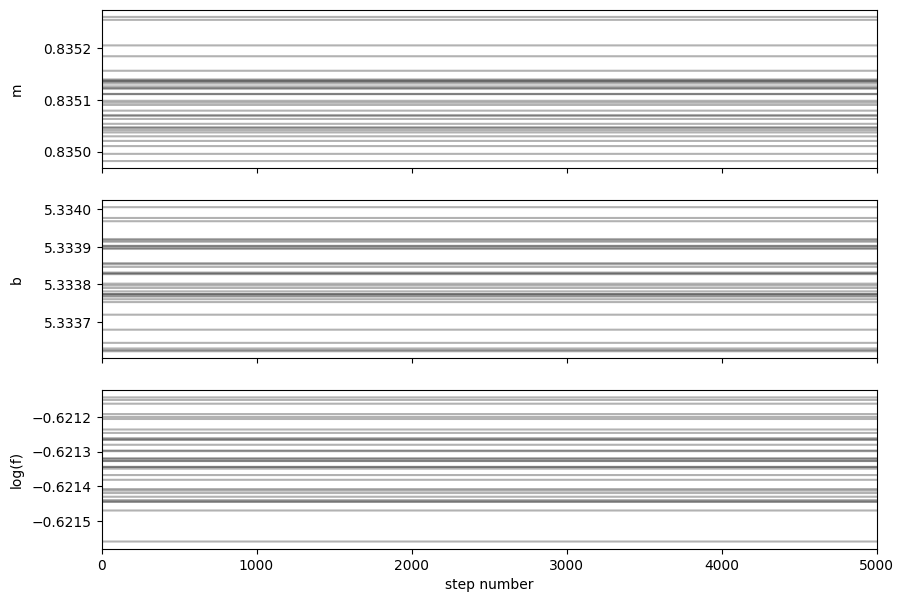

In [20]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [21]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan nan]


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


In [22]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


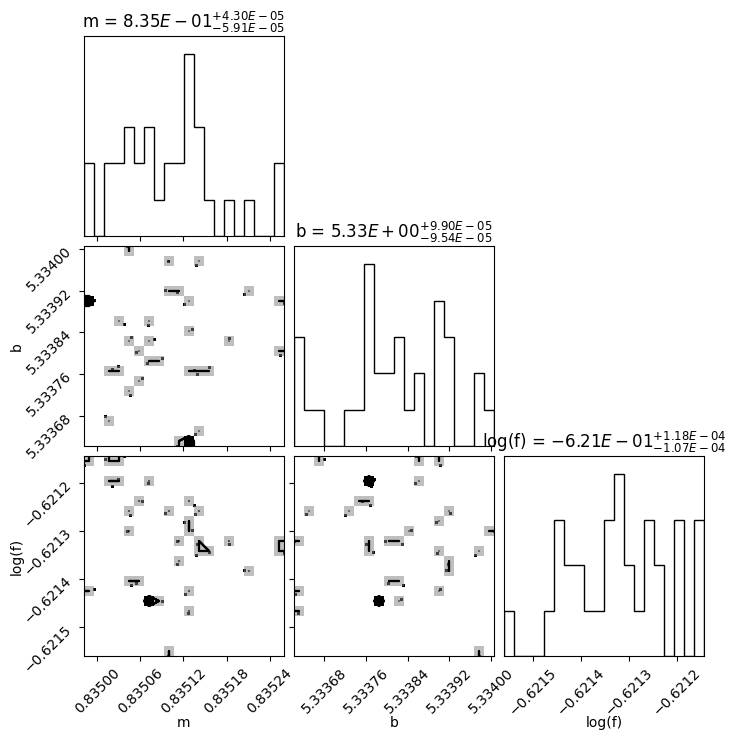

In [23]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

In [24]:
# Extract the samples
samples = sampler.get_chain()

# Calculate mean and standard deviation for each parameter
mean_theta1 = np.mean(samples[:, :, 0])
std_theta1 = np.std(samples[:, :, 0])

mean_theta2 = np.mean(samples[:, :, 1])
std_theta2 = np.std(samples[:, :, 1])

mean_sigma = np.mean(samples[:, :, 2])
std_sigma = np.std(samples[:, :, 2])

# Print the results
print("Theta1: {:.3f} ± {:.3f}".format(mean_theta1, std_theta1))
print("Theta2: {:.3f} ± {:.3f}".format(mean_theta2, std_theta2))
print("Sigma: {:.3f} ± {:.3f}".format(mean_sigma, std_sigma))


Theta1: 0.835 ± 0.000
Theta2: 5.334 ± 0.000
Sigma: -0.621 ± 0.000
